x_prev1 0.1
x_prev2 1.1
x 0.005
x_prev1 0.005
x_prev2 0.1
x 0.005
x_prev1 0.005
x_prev2 0.005
x 0.005
x_prev1 0.1
x_prev2 1.1
x 0.005
x_prev1 0.005
x_prev2 0.1
x 0.005
x_prev1 0.005
x_prev2 0.005
x 0.005
x_prev1 0.1
x_prev2 1.1
x 0.005
x_prev1 0.005
x_prev2 0.1
x 0.005
x_prev1 0.005
x_prev2 0.005
x 0.005
x_prev1 0.1
x_prev2 1.1
x 0.005
x_prev1 0.005
x_prev2 0.1
x 0.005
x_prev1 0.005
x_prev2 0.005
x 0.005
x_prev1 0.1
x_prev2 1.1
x 0.005
x_prev1 0.005
x_prev2 0.1
x 0.005
x_prev1 0.005
x_prev2 0.005
x 0.005
x_prev1 0.1
x_prev2 1.1
x 0.005
x_prev1 0.005
x_prev2 0.1
x 0.005
x_prev1 0.005
x_prev2 0.005
x 0.005
x_prev1 0.1
x_prev2 1.1
x 0.005
x_prev1 0.005
x_prev2 0.1
x 0.005
x_prev1 0.005
x_prev2 0.005
x 0.005
x_prev1 0.1
x_prev2 1.1
x 0.005
x_prev1 0.005
x_prev2 0.1
x 0.005
x_prev1 0.005
x_prev2 0.005
x 0.005
x_prev1 0.1
x_prev2 1.1
x 0.005
x_prev1 0.005
x_prev2 0.1
x 0.005
x_prev1 0.005
x_prev2 0.005
x 0.005
x_prev1 0.1
x_prev2 1.1
x 0.005000000000000001
x_prev1 0.005000000000000001
x_prev

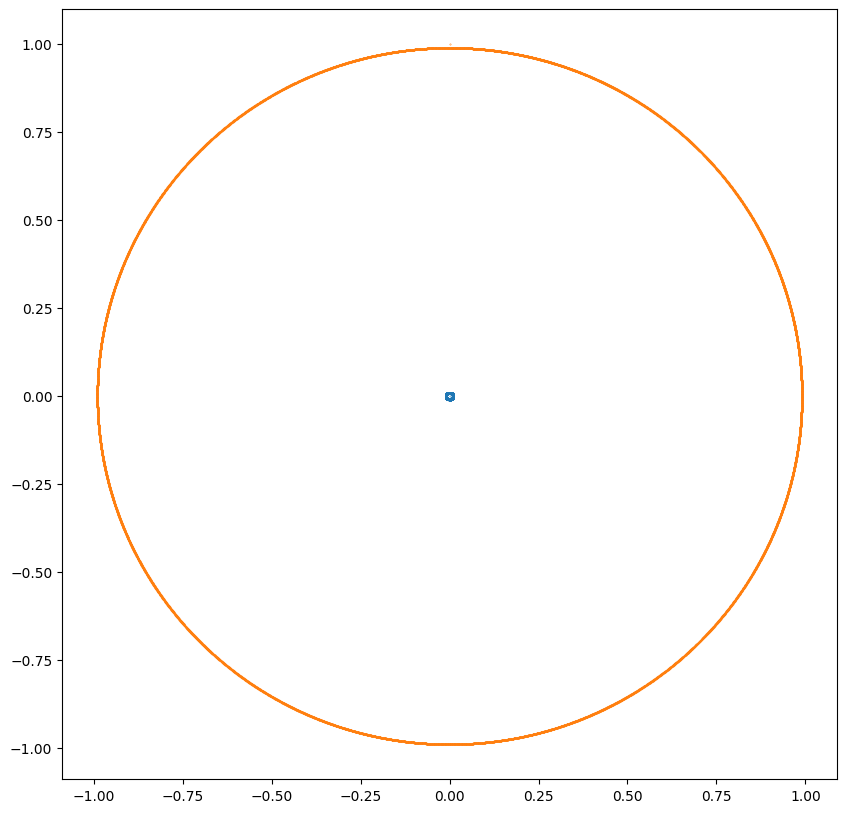

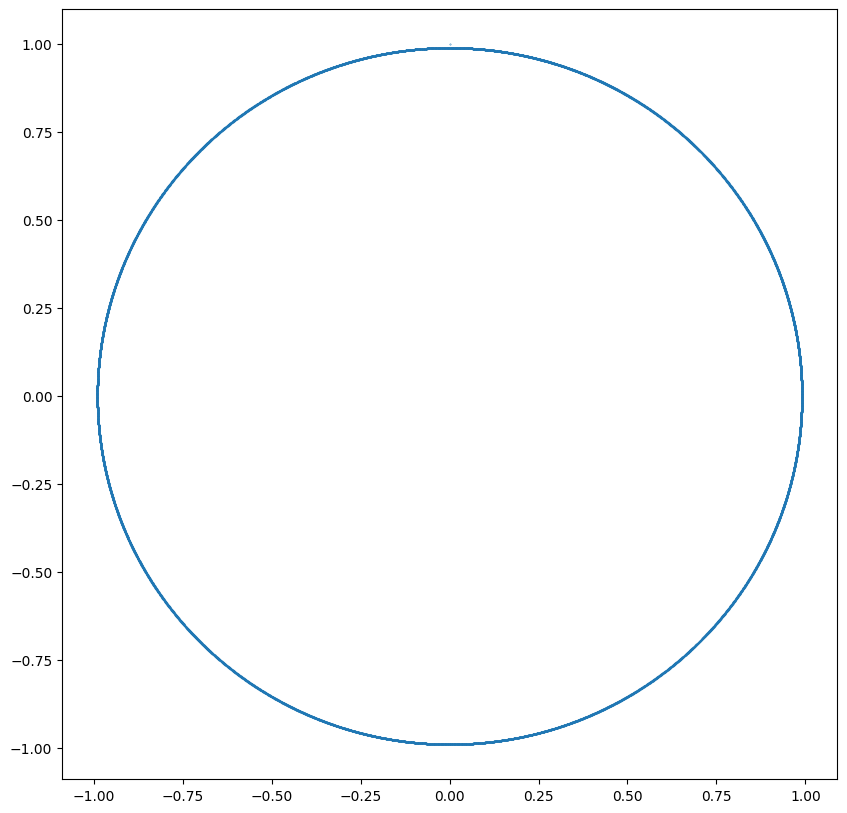

In [22]:
import numpy as np
import math

# Calculate c(z) for n=0 to 5
def c_stumpff(z):
    n=0
    while z > 0.1:
        z/=4
        n+=1
    c4 = 1/math.factorial(4) - z/math.factorial(6)
    c5 = 1/math.factorial(5) - z/math.factorial(7)
    z_bar = -z
    p = z_bar
    k = 8
    not_converged = True
    while not_converged:
        c4_prv = c4
        p = p*z_bar
        c4 = c4 + p/math.factorial(k)
        k += 1
        c5 = c5 + p/math.factorial(k)
        k += 1
        if c4 == c4_prv:
            not_converged = False
    c3 = 1/6 - z*c5
    c2 = 1/2 - z*c4
    c1 = 1 - z*c3
    while n > 0:
        z = 4.*z
        c5 = 0.0625*(c5+c4+c3*c2) # in paper pseudocode c3 and c2 are added
        c4 = 0.125*c3*(1+c1) # in paper pseudocode these are subtracted
        c3 = 1./6.-z*c5
        c2 = 0.5-z*c4
        c1 = 1.-z*c3 
        n -= 1
    c0 = 1. - z*c2
    return c0,c1,c2,c3,c4,c5

def cartesianToJacobi(r,m):
    R = m[0]*r[0]
    r_prime = np.zeros((len(r),3))
    for i in range(1,len(m)):
        r_prime[i] = r[i] - R/np.sum(m[:i])
        R = R*(1+m[i]/np.sum(m[:i])) + m[i]*r_prime[i]
    r_prime[0] = R / np.sum(m[:len(m)-1])
    return r_prime

def jacobiToCartesian(r_prime,m):
    R = r_prime[0]*np.sum(m[:len(m)-1])
    r = np.zeros((len(r_prime),3))
    for i in range(len(m)-1,0,-1):
        R = (R-m[i]*r_prime[i])/np.sum(m[:i+1])
        r[i] = r_prime[i] + R
        R = R*np.sum(m[:i])
    r[0] = R/m[0]
    return r

def G(beta,X,n):
    return X**n*c_stumpff(beta*X**2)[n]

# returns position and velocity of a single mass after a time dt
def newtonKepler(X_0,r_0,v_0,m,dt):
    M = np.max(m)
    beta = 2*M/np.linalg.norm(r_0) - np.linalg.norm(v_0)**2
    eta_0 = np.dot(r_0,v_0)
    zeta_0 = M - beta*np.linalg.norm(r_0)
    X = X_0
    X_prev1 = X_0 + 1.
    precision = 1e-12
    while (X_prev1 != X) or (X_prev2 != X):
    # while np.abs(X_prev1 - X) > precision:
        X_prev2 = X_prev1
        X_prev1 = X
        X = (X*(eta_0*G(beta,X,1) + zeta_0*G(beta,X,2)) - eta_0*G(beta,X,2) - zeta_0*G(beta,X,3) + dt)/(np.linalg.norm(r_0) + eta_0*G(beta,X,1) + zeta_0*G(beta,X,2))
        print("x_prev1",X_prev1)
        print("x_prev2",X_prev2)
        print("x",X)
    f = 1 - (M*G(beta,X,2))/np.linalg.norm(r_0)
    g = dt - M*G(beta,X,3)
    r = np.linalg.norm(r_0) + eta_0*G(beta,X,1) + zeta_0*G(beta,X,2)
    f_dot = -M*G(beta,X,1)/(r*np.linalg.norm(r_0))
    g_dot = 1 - M*G(beta,X,2)/r
    return f*r_0 + g*v_0,f_dot*r_0 + g_dot*v_0

# Test
masses = np.array([1,0.01])
r_0 = np.array([[0,0,0],[0,1.,0]])
v_0 = np.array([[0,0,0],[1.,0,0]])
dt = 0.01
time = np.arange(1,130,dt)
r_0_jacob = np.zeros((len(time),len(masses),3))
v_0_jacob = np.zeros((len(time),len(masses),3))

# start in jacobi coords for drift 
r_0_jacob[0] = cartesianToJacobi(r_0,masses)
v_0_jacob[0] = cartesianToJacobi(v_0,masses)
for i in range(1,len(time)):
    for j in range(1,len(masses)): # DO NOT KEPLER SOLVE FIRST MASS! 
        r_0_jacob[i,j], v_0_jacob[i,j] = newtonKepler(0.1,r_0_jacob[i-1,j],v_0_jacob[i-1,j],masses,dt/2)
        #print(r_0_jacob[i-1,1])

        # convert back to cartesian for kick

        # convert back to jacobi for drift

cartesian = np.array([jacobiToCartesian(r_0_jacob[i],masses) for i in range(len(time))])

print(cartesian)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
plt.scatter(cartesian[:,0,0],cartesian[:,0,1],s=0.1)
plt.scatter(cartesian[:,1,0],cartesian[:,1,1],s=0.1)
plt.show()

fig = plt.figure(figsize=(10,10))
plt.scatter(cartesian[:,1,0],cartesian[:,1,1],s=0.1)
plt.show()

